### Setting up Colab and Github 

In [1]:
import os 
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Innolab github/Connectome')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [171]:
!git status

On branch gb-tuning
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../notebooks/gradient_boosting_untuned.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../notebooks/gb_tuning.ipynb
	../src/__pycache__/
	../src/preprocessing/__pycache__/

no changes added to commit (use "git add" and/or "git commit -a")


### Importing Libraries

In [151]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 


from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import scipy.stats
import src.preprocessing.data_loader as dtl
from math import sqrt
from datetime import date

plt.style.use("ggplot")
%matplotlib inline



In [23]:
def plot_av_data(dataset: pd.DataFrame, cols: int = 20) -> None:
    sns.heatmap(dataset.iloc[:, 0:cols].isnull())
    plt.show()


def pred_evaluation(true: np.ndarray, preds: np.ndarray,
                    model: str = "Model") -> pd.DataFrame:
    """
    evaluates the given predictions

    Args:
        true:
        preds:
        model:

    Returns:
        Pandas Dataframe with several evaluation metrics

    Raises:
        KeyError: ...
    """

    accuracy = accuracy_score(true, preds)
    precision = precision_score(true, preds)
    recall = recall_score(true, preds)
    f1 = f1_score(true, preds)
    auc = roc_auc_score(true, preds)

    res = pd.DataFrame({"Accuracy": [accuracy],
                        "Precision": [precision],
                        "Recall": [recall],
                        "F1": [f1],
                        "AUC": [auc]})
    res.index = list(model) * len(res)
    return res


def evaluate_cv_scores(cv_scores: np.ndarray, title: str = "") -> None:
    eval_stats = {"Std.": (np.std(cv_scores)), "Mean": (cv_scores.mean()), "Max": (max(cv_scores)),
                  "Min": (min(cv_scores)), "Median": np.median(cv_scores)}

    print("CV Accuracy Evaluation", title)
    print("-"*35)
    for stat, val in eval_stats.items():
        print("{:20}{:>15.4f}".format(stat + ":", val))

### Loading and Transforming Data

In [4]:
%%time
train = dtl.load_data(True)
test = dtl.load_data(False)

Input path to train dataset (with name + .csv): /content/drive/MyDrive/Colab Notebooks/Innolab/train.csv
Input path to test dataset (with name + .csv): /content/drive/MyDrive/Colab Notebooks/Innolab/test.csv
CPU times: user 22.3 s, sys: 667 ms, total: 23 s
Wall time: 49.2 s


In [5]:
y, X = dtl.preprocess_data(train)
X = X.drop(columns = ['MEM_score', 'Apoe'], inplace = False)
y_test, X_test = dtl.preprocess_data(test)
X_test = X_test.drop(columns = ['MEM_score', 'Apoe'], inplace = False)

### Baseline Model (XGB Untuned Classifier)

In [47]:
%%time
xgb_baseline = xgb.XGBClassifier(tree_method='gpu_hist')
xgb_baseline.fit(X,y)



CPU times: user 8.49 s, sys: 6.39 s, total: 14.9 s
Wall time: 14.8 s


In [43]:
xgb_baseline

XGBClassifier(predictor='gpu_predictor', updater='grow_gpu')

Text(0, 0.5, 'Feature Importance Score')

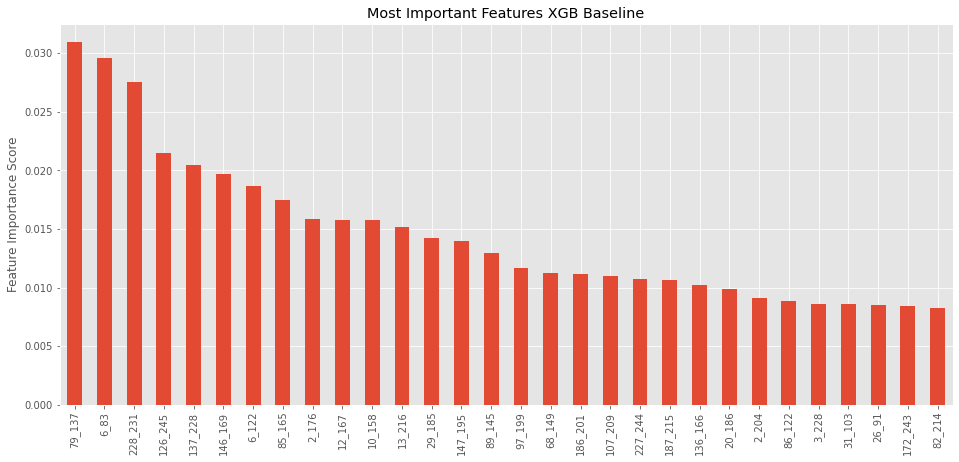

In [44]:
features = list(X.columns)
feat_imp = pd.Series(xgb_baseline.feature_importances_, features).sort_values(ascending=False)
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(7)
feat_imp[0:30].plot(kind='bar', title='Most Important Features XGB Baseline')
plt.ylabel('Feature Importance Score')


In [45]:
print('Accuracy of the GBM on test set: {:.3f}'.format(xgb_baseline.score(X_test, y_test)), "\n")
pred = xgb_baseline.predict(X_test)
print("Classification Report - XGB Baseline [Test]")
print(classification_report(y_test, pred))

Accuracy of the GBM on test set: 0.776 

Classification Report - XGB Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.78      0.68      0.72        37
         1.0       0.77      0.85      0.81        48

    accuracy                           0.78        85
   macro avg       0.78      0.76      0.77        85
weighted avg       0.78      0.78      0.77        85



### Evaluating the Untuned Model via Repeated CV

In [48]:
%%time
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
n_scores = cross_val_score(xgb_baseline, X, y, scoring='accuracy', cv=cv, error_score='raise')
print("CV Accuracy: {:.2f}".format(n_scores.mean()))

CV Accuracy: 0.73
CPU times: user 4min 17s, sys: 1min 55s, total: 6min 13s
Wall time: 6min 11s


In [49]:
evaluate_cv_scores(n_scores, "- XGB Baseline")

CV Accuracy Evaluation - XGB Baseline
-----------------------------------
Std.:                        0.0559
Mean:                        0.7319
Max:                         0.8684
Min:                         0.6316
Median:                      0.7274


###XGB HPO

In [55]:
def sample_configs(budget, config_ranges):
  sampled_configs = []

  for i in range(budget):
    interm_dict = {}
    for hyp_param in config_ranges.keys():
      interm_dict[hyp_param] = np.random.choice(config_ranges[hyp_param])
    
    sort_int = sorted(interm_dict) 
    sampled_configs.append(dict(zip(sort_int , [interm_dict[i] for i in sort_int])))

  return sampled_configs

In [120]:
n = len(X)
p = len(X.columns)
CONFIG_RANGES_XGB = {'min_samples_split': [round(0.005*n), round(0.01*n), round(0.015*n), round(0.0075*n)],
                 'min_weight_fraction_leaf': [0.005, 0.0075, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1],
                 'max_depth': [2, 3, 4, 5, 6, 7, 8, 10],
                 'max_features': ['sqrt',round(0.01*p), round(0.03*p), round(0.05*p) , round(0.1*p), round(0.2*p), round(0.3*p)],
                 'learning_rate': [1e-4, 1e-3, 1e-2,1e-1, 2e-1, 3e-1, 4e-1, 5e-1],
                 'n_estimators': [50, 100, 250, 500, 750, 1000, 1250],
                 'subsample': [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95,1, 1, 1, 1],
                 #'presort':,
                 'tree_method': ['gpu_hist'],
                 'reg_lambda': [0],
                 'reg_alpha': [0],
                 'sampling_method': ['uniform', 'gradient_based'],
                 'objective': ['binary:logistic']}

In [127]:
sample_configs(1, CONFIG_RANGES_XGB)

[{'learning_rate': 0.0001,
  'max_depth': 10,
  'max_features': '301',
  'min_samples_split': 6,
  'min_weight_fraction_leaf': 0.02,
  'n_estimators': 500,
  'objective': 'binary:logistic',
  'reg_alpha': 0,
  'reg_lambda': 0,
  'sampling_method': 'gradient_based',
  'subsample': 0.6,
  'tree_method': 'gpu_hist'}]

In [95]:
def init_classif(config):
  classif = xgb.XGBClassifier(learning_rate=config['learning_rate'],
                min_weight_fraction_leaf=config['min_weight_fraction_leaf'],
                max_depth=config['max_depth'],
                max_features=config['max_features'],
                min_samples_split=config['min_samples_split'],
                n_estimators=config['n_estimators'],
                objective=config['objective'],
                reg_alpha=config['reg_alpha'],
                reg_lambda=config['reg_lambda'],
                sampling_method=config['sampling_method'],
                subsample=config['subsample'],
                tree_method=config['tree_method'])
  return classif

In [131]:
test_1 = init_classif(sample_configs(1, CONFIG_RANGES_XGB)[0])
test_2 = init_classif(sample_configs(1, CONFIG_RANGES_XGB)[0])
print(test_1)
print(test_2)

XGBClassifier(learning_rate=0.5, max_depth=8, max_features='6028',
              min_samples_split=2, min_weight_fraction_leaf=0.0075,
              n_estimators=500, reg_lambda=0, sampling_method='gradient_based',
              subsample=1.0, tree_method='gpu_hist')
XGBClassifier(learning_rate=0.0001, max_depth=10, max_features='1507',
              min_samples_split=2, min_weight_fraction_leaf=0.02,
              n_estimators=500, reg_lambda=0, sampling_method='uniform',
              subsample=0.8, tree_method='gpu_hist')


In [141]:
def do_hpo(budget: int, configs: dict, cv: bool = False):
  if cv:
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=123)
  else: 
    X_train_h, X_val, y_train_h, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  
  sampled_configs = sample_configs(budget, configs)
  config_scores = {}

  for i, config in enumerate(sampled_configs):
    print("-"*50, "fitting config ", str(i+1)+"/"+str(budget))
    classif = init_classif(config)
    if cv:
      n_scores = cross_val_score(classif, X, y, scoring='accuracy', cv=cv, error_score='raise')
      config_scores[i] = n_scores.mean()
    else: 
      classif.fit(X_train_h,y_train_h)
      config_scores[i] = classif.score(X_test, y_test)
      

  return config_scores, sampled_configs

In [160]:
%%time
budget = 100
config_scores = do_hpo(budget, CONFIG_RANGES_XGB)

-------------------------------------------------- fitting config  1/100
-------------------------------------------------- fitting config  2/100
-------------------------------------------------- fitting config  3/100
-------------------------------------------------- fitting config  4/100
-------------------------------------------------- fitting config  5/100
-------------------------------------------------- fitting config  6/100
-------------------------------------------------- fitting config  7/100
-------------------------------------------------- fitting config  8/100
-------------------------------------------------- fitting config  9/100
-------------------------------------------------- fitting config  10/100
-------------------------------------------------- fitting config  11/100
-------------------------------------------------- fitting config  12/100
-------------------------------------------------- fitting config  13/100
-----------------------------------------------

### Saving Config Scores to File

In [161]:
dev_accs = pd.Series(config_scores[0].values())
hpo_res = pd.DataFrame(config_scores[1])
hpo_res["dev_accs"] = dev_accs

In [162]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Innolab github/Connectome/results") #path where the hpo results are stored
filename_xgb = "hpo_xgb_results_budget_" + str(budget) + "_" + str(date.today()) + ".csv" 
hpo_res.to_csv(filename_xgb)

In [164]:
hpo_res.sort_values("dev_accs")

,learning_rate,max_depth,max_features,min_samples_split,min_weight_fraction_leaf,n_estimators,objective,reg_alpha,reg_lambda,sampling_method,subsample,tree_method,dev_accs
99,0.5000,10,9041,6,0.0500,100,binary:logistic,0,0,uniform,0.50,gpu_hist,0.600000
98,0.5000,10,301,2,0.0100,1250,binary:logistic,0,0,uniform,0.70,gpu_hist,0.600000
9,0.0001,2,3014,4,0.0150,50,binary:logistic,0,0,uniform,1.00,gpu_hist,0.611765
93,0.3000,10,6028,6,0.0075,50,binary:logistic,0,0,uniform,0.70,gpu_hist,0.623529
20,0.5000,7,3014,4,0.0200,50,binary:logistic,0,0,gradient_based,0.90,gpu_hist,0.635294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.1000,10,9041,2,0.0500,500,binary:logistic,0,0,uniform,0.70,gpu_hist,0.776471
96,0.1000,2,904,6,0.0100,1000,binary:logistic,0,0,uniform,0.85,gpu_hist,0.776471
95,0.0010,10,1507,4,0.0300,1000,binary:logistic,0,0,gradient_based,0.60,gpu_hist,0.788235
56,0.1000,7,1507,2,0.1000,250,binary:logistic,0,0,gradient_based,0.80,gpu_hist,0.800000


In [170]:
!git config --global user.email "leoschaabner@gmx.de"
!git config --global user.name "leoschaabner"
!git add .
!git commit -m "added xgb tuning"

[gb-tuning 1c1abd1] added xgb tuning
 1 file changed, 101 insertions(+)
 create mode 100644 results/hpo_xgb_results_budget_100_2021-12-15.csv


In [174]:
!git status

On branch gb-tuning
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../notebooks/gradient_boosting_untuned.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../notebooks/gb_tuning.ipynb
	../src/__pycache__/
	../src/preprocessing/__pycache__/

no changes added to commit (use "git add" and/or "git commit -a")


In [182]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Innolab github/Connectome")
!git add .
!git commit -m "added xgb tuning"

[gb-tuning ea173fc] added xgb tuning
 4 files changed, 1 insertion(+), 1 deletion(-)
 create mode 100644 src/__pycache__/__init__.cpython-37.pyc
 create mode 100644 src/preprocessing/__pycache__/__init__.cpython-37.pyc
 create mode 100644 src/preprocessing/__pycache__/data_loader.cpython-37.pyc


In [186]:
!git

* gb-tuning
  main
  remotes/origin/HEAD -> origin/main
  remotes/origin/main


### Same for LGB